In [4]:
# Common imports
import os
import io
import sklearn
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
train_df = pd.read_csv( "./sample_data/train.csv")
test_df = pd.read_csv("./sample_data/test.csv")
train_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# Some data is missing but we only require age from the missing values
# Drop the irrelevant data 'Name','Cabin','Ticket','Embarked'
def process(df):
  df['Sex'] = (df['Sex'] == 'female').astype(int)
  df['Age'].fillna(value=df['Age'].mean(), inplace=True)
  df['Fare'].fillna(value=df['Fare'].mean(), inplace=True)
  if df.columns.isin(['Name','Cabin','Ticket','Embarked']).any():
    df=df.drop(columns=['Name','Cabin','Ticket','Embarked'])
  # We know age and sex played an important role in the survival of the sinking titanic
  # We can use that to engineer a new feature
  df['S&A']=(df['Sex']+1)*df['Age'] 
  return df
train_df=process(train_df)
test_df=process(test_df)
train_df.info() 
test_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   S&A          891 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 62.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    float64
 4   SibSp        418 non-n

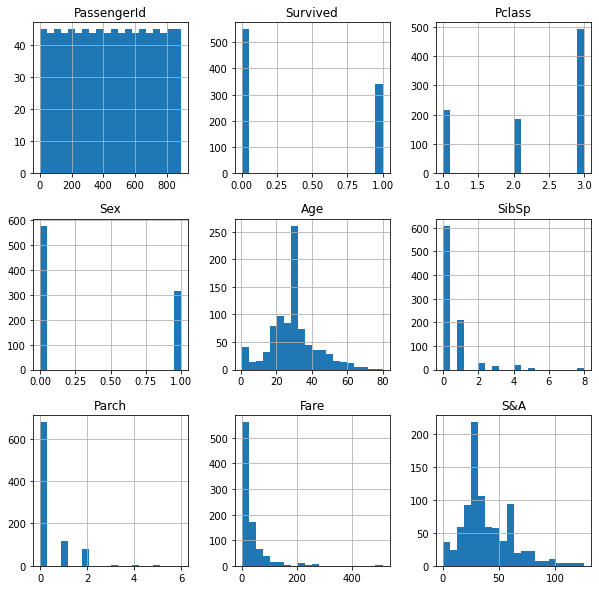

In [7]:
train_df.describe()
train_df.hist(bins=20, figsize=(10,10))
plt.show()

In [8]:
corr_matrix = train_df.corr()
corr_matrix["Survived"].sort_values(ascending=False)
#suggests strong correlation between fare and surviving  
#negative correlation with ticket class however that may be due to lower number of tickets in the higher class

Survived       1.000000
Sex            0.543351
S&A            0.306594
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.069809
Pclass        -0.338481
Name: Survived, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fafe28d40a0>,
      dtype=object)

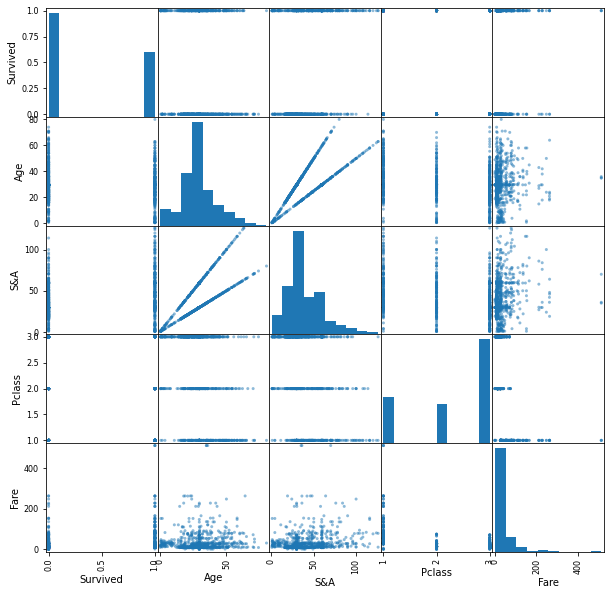

In [9]:
from pandas.plotting import scatter_matrix
plotted_features=['Survived','Age','S&A','Pclass','Fare']
scatter_matrix(train_df[plotted_features], figsize=(10, 10))

In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def crossValMetrics(alg,X_train,y_train,y_test, y_pred):
  y_train_pred = cross_val_predict(alg, X_train, y_train, cv=3)
  # TP|FP
  # FN|TN 
  cm=confusion_matrix(y_train, y_train_pred)
  print(f"True Positive {cm[0][0]} | False Positive {cm[0][1]} \nFalse Negative {cm[1][0]} | True Negative {cm[1][1]} ")
  print(classification_report(y_test, y_pred))

In [11]:
# y contains the class I am trying to predict. In this case its survivability
y=train_df['Survived']
X=train_df.drop(columns=['Survived'])
X_Pred=test_df
# 70% of the training data is being kept seperate to evaluate the model
# 30% goes in Test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [12]:
# Runs random forrest to train the model 
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

In [13]:
crossValMetrics(random_forest,X_train,y_train,y_test, y_pred)

True Positive 318 | False Positive 43 
False Negative 72 | True Negative 163 
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       188
           1       0.76      0.76      0.76       107

    accuracy                           0.83       295
   macro avg       0.81      0.81      0.81       295
weighted avg       0.83      0.83      0.83       295



In [14]:
y_pred_test=random_forest.predict(X_Pred)
X_Pred['Survived']=y_pred_test
y_pred_test_df=X_Pred['Survived']
X_Pred=X_Pred.drop(columns=['Survived'])
#y_pred_test_df.to_csv('submission.csv', index=False)